{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 2, 54: 2, 55: 1, 56: 1, 57: 1, 58: 1, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 1, 87: 1, 88: 1, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 1, 99: 1, 100: 0, 101: 0, 102: 0, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 0, 110: 0, 111: 2, 112: 2, 113: 0, 114: 0, 115: 1, 116: 1, 117: 0, 118: 0, 119: 1, 120: 1, 121: 0, 122: 0, 123: 0, 124: 0, 125: 3, 126: 3, 127: 1, 128: 1, 129: 0, 130: 0, 131: 0, 132: 1, 133: 1, 134: 0, 135: 0, 136: 0, 137: 0, 138: 

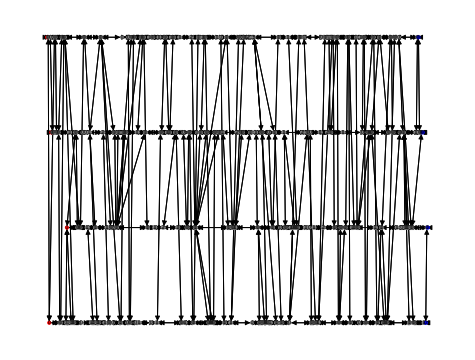

In [2]:
from Partition import *

NQubit = 4
Depth = 200

def main():
    gs, input_nodes, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    labels = nx.get_node_attributes(gs, 'layer')
    node_pos = nx.get_node_attributes(gs, 'pos')
    nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=5)
    print(labels)
    return

if __name__ == '__main__':
    main()